# Support Vector Machine (SVM)

## features

In [1]:
import finlab.ml as ml

dataset = ml.fundamental_features()
dataset.head()

R101_ROA稅後息前  R11V_ROA綜合損益  R103_ROE稅後  R11U_ROE綜合損益  \
stock_id date                                                               
000116   2013-05-15           NaN           NaN         NaN           NaN   
         2013-08-14           NaN           NaN         NaN           NaN   
         2013-11-14           NaN           NaN         NaN           NaN   
         2014-03-31           NaN           NaN         NaN           NaN   
         2014-05-15           NaN           NaN         NaN           NaN   

                     R145_稅前息前折舊前淨利率  R105_營業毛利率  R106_營業利益率  R107_稅前淨利率  \
stock_id date                                                              
000116   2013-05-15              NaN         NaN         NaN         NaN   
         2013-08-14              NaN         NaN         NaN         NaN   
         2013-11-14              NaN         NaN         NaN         NaN   
         2014-03-31              NaN         NaN         NaN         NaN   
         2014-05-15              NaN         NaN         NaN         NaN   

                     R108_稅後淨利率  R112_業外收支營收率  ...  R409_淨值成長率  R501_流動比率  \
stock_id date                                  ...                          
000116   2013-05-15         NaN           NaN  ...         NaN        NaN   
         2013-08-14         NaN           NaN  ...         NaN        NaN   
         2013-11-14         NaN           NaN  ...         NaN        NaN   
         2014-03-31         NaN           NaN  ...         NaN        NaN   
         2014-05-15         NaN           NaN  ...         NaN        NaN   

                     R502_速動比率  R503_利息支出率  R678_營運資金  R607_總資產週轉次數  \
stock_id date                                                         
000116   2013-05-15        NaN         NaN        NaN           NaN   
         2013-08-14        NaN         NaN        NaN           NaN   
         2013-11-14        NaN         NaN        NaN           NaN   
         2014-03-31        NaN         NaN        NaN           NaN   
         2014-05-15        NaN         NaN        NaN           NaN   

                     R610_存貨週轉率  R612_固定資產週轉次數  R613_淨值週轉率次  R69B_自由現金流量  
stock_id date                                                             
000116   2013-05-15         NaN            NaN          NaN          NaN  
         2013-08-14         NaN            NaN          NaN          NaN  
         2013-11-14         NaN            NaN          NaN          NaN  
         2014-03-31         NaN            NaN          NaN          NaN  
         2014-05-15         NaN            NaN          NaN          NaN  

[5 rows x 41 columns]

In [2]:
dataset.columns
features = ['R103_ROE稅後', 'R402_營業毛利成長率']
dataset = dataset[features].dropna(how='any')
dataset.head()

R103_ROE稅後  R402_營業毛利成長率
stock_id date                                
1101     2014-05-15    1.789978     55.708493
         2014-08-14    5.481276     27.022920
         2014-11-14    9.817990     -5.396195
         2015-03-31   12.657647    -11.807846
         2015-05-15    0.601114    -41.181555

## add prediction

In [3]:
ml.add_profit_prediction(dataset)
dataset.head()

R103_ROE稅後  R402_營業毛利成長率    return
stock_id date                                          
1101     2014-05-15    1.789978     55.708493  1.073347
         2014-08-14    5.481276     27.022920  0.984816
         2014-11-14    9.817990     -5.396195  0.969163
         2015-03-31   12.657647    -11.807846  0.956818
         2015-05-15    0.601114    -41.181555  0.850077

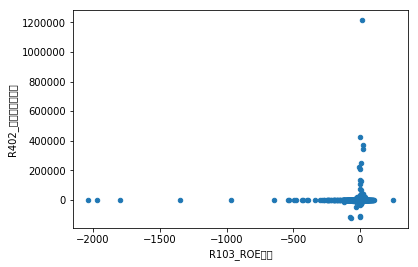

In [4]:
%matplotlib inline
dataset.plot.scatter(features[0], features[1])

## remove outliers

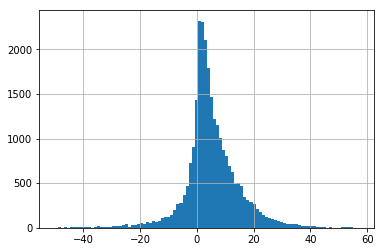

In [5]:
def is_valid(feature, nstd):
    ub = feature.mean() + nstd * feature.std()
    lb = feature.mean() - nstd * feature.std()

    return (feature > lb) & (feature <ub)

valid = is_valid(dataset['R103_ROE稅後'], 2) & is_valid(dataset['R402_營業毛利成長率'], 0.05)
dataset_rmoutliers = dataset[valid].dropna()

dataset_rmoutliers['R103_ROE稅後'].hist(bins=100)
#dataset_rmoutliers['R402_營業毛利成長率'].hist(bins=100)

## Scale features

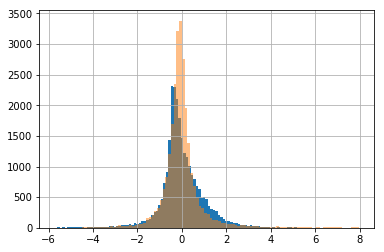

In [7]:
import pandas as pd
import sklearn.preprocessing as preprocessing

dataset_scaled = pd.DataFrame(preprocessing.scale(dataset_rmoutliers), index=dataset_rmoutliers.index, columns=dataset_rmoutliers.columns)
dataset_scaled.head()

dataset_scaled['R103_ROE稅後'].hist(bins=100)
dataset_scaled['R402_營業毛利成長率'].hist(bins=100, alpha=0.5)
dataset_scaled['return'] = dataset_rmoutliers['return']


## Training

In [8]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(dataset_scaled, test_size=0.1, random_state=0)

from sklearn.svm import SVC

cf = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

cf.fit(dataset_train[features], dataset_train['return'] > dataset_train['return'].quantile(0.5))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

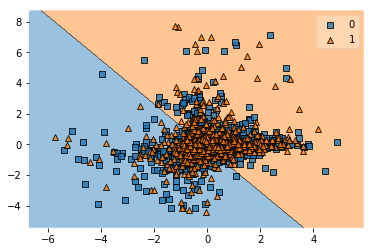

In [10]:
from mlxtend.plotting import plot_decision_regions

features_plot = dataset_test[features].values
labels_plot = (dataset_test['return'] > dataset_test['return'].quantile(0.5)).astype(int).values

plot_decision_regions(features_plot, labels_plot, cf)

## backtest

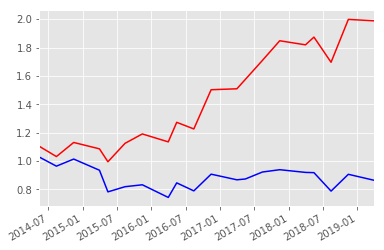

In [12]:
history = dataset_test.copy()
history['svm prediction'] = cf.predict(dataset_test[features])
history = history.reset_index()

dates = sorted(list(set(history['date'])))

seasonal_returns1 = []
seasonal_returns2 = []
for date in dates:
    current_stocks = history[history['date'] == date]
    buy_stocks = current_stocks[current_stocks['svm prediction'] == True]
    sell_stocks = current_stocks[current_stocks['svm prediction'] == False]
    
    seasonal_return1 = buy_stocks['return'].mean()
    seasonal_returns1.append(seasonal_return1)
    
    seasonal_return2 = sell_stocks['return'].mean()
    seasonal_returns2.append(seasonal_return2)

import matplotlib.pyplot as plt
plt.style.use("ggplot")

pd.Series(seasonal_returns1, index=dates).cumprod().plot(color='red')
pd.Series(seasonal_returns2, index=dates).cumprod().plot(color='blue')